# Project 2: Natural Language Processing
Authors: Zechen Wu, Elena Franchini

# Investigate dataset

## Dataset selection
The dataset we will use is the "SQuAD2.0: The Stanford Question Answering Dataset". The website provides the training and validation (i.e. development) set in the form of JSON.


## Dataset analysis
Data in the training set consists of strings which represent questions and answers (that come from Wikipedia articles) and can be found as values under the 'data' key. Each 'title' key is associated to a 'paragraphs' key which is an array containing these questions and answers associated to that title (the title acts as a category). Each question is composed by the text representing the question, the id, an array of answers and a flag checking if answering to that question is impossible: if the flag is true, the array of answers is empty. In addition, each answer is associated to the 'answer_start' key whose value represent the starting position of the answer.
Some questions have also plausible answers, which should be other possible answers in addition to the correct ones (if any).

In [2]:
!git clone https://github.com/Ele975/AML_project2.git
!pip install --upgrade gensim
!pip install ffmpeg-python
!pip install -U openai-whisper
!pip install noisereduce
!pip install pydub

fatal: destination path 'AML_project2' already exists and is not an empty directory.


In [3]:
import pandas as pd
import numpy as np
import json
import math
import io
import re
import nltk
import ffmpeg
import whisper
import scipy
import urllib.request
import librosa
import matplotlib
import noisereduce as nr
import torch

from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from gensim.models import phrases
from matplotlib import pyplot as plt
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read

nltk.download('stopwords')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# import data from github repository
train = pd.read_json('AML_project2/train-v2.0.json')
val = pd.read_json('AML_project2/dev-v2.0.json')
print(train)
print(val)

    version                                               data
0      v2.0  {'title': 'Beyoncé', 'paragraphs': [{'qas': [{...
1      v2.0  {'title': 'Frédéric_Chopin', 'paragraphs': [{'...
2      v2.0  {'title': 'Sino-Tibetan_relations_during_the_M...
3      v2.0  {'title': 'IPod', 'paragraphs': [{'qas': [{'qu...
4      v2.0  {'title': 'The_Legend_of_Zelda:_Twilight_Princ...
..      ...                                                ...
437    v2.0  {'title': 'Infection', 'paragraphs': [{'qas': ...
438    v2.0  {'title': 'Hunting', 'paragraphs': [{'qas': [{...
439    v2.0  {'title': 'Kathmandu', 'paragraphs': [{'qas': ...
440    v2.0  {'title': 'Myocardial_infarction', 'paragraphs...
441    v2.0  {'title': 'Matter', 'paragraphs': [{'qas': [{'...

[442 rows x 2 columns]
   version                                               data
0     v2.0  {'title': 'Normans', 'paragraphs': [{'qas': [{...
1     v2.0  {'title': 'Computational_complexity_theory', '...
2     v2.0  {'title': 'Southern_Ca

### Count the number of data we have in both the training and validation sets.
The size of the dataset is quite small, but the partition between the training and validation set is good (since always we have a traning set much bigger than the validation set). Often the dataset is first split in traning and test set, since the validation set is obtained by further splitting the training set. In this case is it required to get the test set from the training set.

In [5]:
def count_data(series):
  nr_categories = 0
  nr_questions = 0
  nr_answers = 0

  for category in series:
    nr_categories += 1
    paragraphs = category.get('paragraphs', [])
    for para in paragraphs:
      qas_list = para.get('qas', [])
      nr_questions += len(qas_list)
      for qas in qas_list:
        answers = qas.get('answers', [])
        nr_answers += len(answers)
  return nr_categories, nr_questions, nr_answers

count_train = count_data(train['data'])
count_val = count_data(val['data']);

print("Categories in the training set:", count_train[0])
print("Categories in the validation set:", count_val[0], "\n")
print("Questions in the training set:", count_train[1])
print("Questions in the validation set:", count_val[1], "\n")
print("Answers in the training set:", count_train[2])
print("Answers in the validation set:", count_val[2], "\n")

print('Total data in training set (Q + A):', count_train[1] + count_train[2])
print('Total data in validation set (Q + A):', count_val[1] + count_val[2], "\n")

print('Total data in dataset (Q + A):', count_train[1] + count_train[2] + count_val[1] + count_val[2], "\n")

print('Partition dataset:')
print('\t Training set:',round((count_train[1] + count_train[2])/(count_train[1] + count_train[2] + count_val[1] + count_val[2])*100) , '%.')
print('\t Validation set:',round((count_val[1] + count_val[2])/(count_train[1] + count_train[2] + count_val[1] + count_val[2])*100) , '%.')


Categories in the training set: 442
Categories in the validation set: 35 

Questions in the training set: 130319
Questions in the validation set: 11873 

Answers in the training set: 86821
Answers in the validation set: 20302 

Total data in training set (Q + A): 217140
Total data in validation set (Q + A): 32175 

Total data in dataset (Q + A): 249315 

Partition dataset:
	 Training set: 87 %.
	 Validation set: 13 %.


### Define the vocabulary size which is given by the number of distinct words in the collection.
To compute the size of the vocabulary (only of the input collection) we need first to split the questions strings (not the answers since we analyse the input only) into words and inserting them in a set which do not allow duplicates (the vocabulary size takes into consideration only distinct words). Regex are used to remove characters we don't need for the analysis and for a potential model, e.g. underscores, numbers, etc. Stop words (most common words) are removed since they don't give additional value for our statistics. In the vocabulary size there are also considered some wrong written words (e.g. aan instead of 'an'), and it is not performant to remove them manually, but since they are only a few with respect to the amount of different words we have, they'll do not influence our results.

In [6]:

# all words
words_total = []


def input_vocabulary(series):
  words_set = set()
  words_total_sets = []

  # list of tokenised questions
  text_to_sentence = []
  text_to_sentence_no_stopwords = []
  for category in series:
    paragraphs = category.get('paragraphs', [])
    for para in paragraphs:
      qas_list = para.get('qas', [])
      for qa in qas_list:
        # set lower case
        question = qa.get('question', '').lower()
        # remove punctuation, split '/' and numbers and words with numbers
        clean_question = re.sub(r'[^\w\s/]', '', question)
        clean_question = re.sub(r'/', ' ', clean_question)
        clean_question = re.sub(r'\b(?:\w*\d\w*|\d+)\b', '', clean_question)
        clean_question = re.sub(r'_', '', clean_question)
        words = clean_question.split()
        text_to_sentence_no_stopwords.append(words)
        # remove stopwords
        words_nostopwords = [w for w in words if w not in stopwords.words('english')]
        text_to_sentence.append(words_nostopwords)
        for word in words_nostopwords:
          # unique words for each set (frequency = 1)
          words_set.add(word)
          # all words for each set
          words_total_sets.append(word)
          # all words for both sets
          words_total.append(word)
  return words_set, words_total_sets, text_to_sentence, text_to_sentence_no_stopwords

words_set_train, words_total_train, text_to_sentence_train, text_to_sentence_no_stopwords_train = input_vocabulary(train['data'])
words_set_val, words_total_val, text_to_sentence_val, text_to_sentence_no_stopwords_val = input_vocabulary(val['data'])

print("vocabulary size of training set:", len(words_set_train))
print("vocabulary size of validation set:", len(words_set_val))
print("total vocabulary size of collection:",  len(words_set_train) + len(words_set_val))


vocabulary size of training set: 44919
vocabulary size of validation set: 9835
total vocabulary size of collection: 54754


### Distributions over document length
To compute the distributions over the document length at first we counts the frequency of each term within the input collection. Here we can notice the words written incorrectly are the ones which can be rarely found in the collection (one or few occurences), but again we cannot remove them since there are a lot of grammatically correct words that also occurs rarely. An additional observation is the fact that the training and validation sets have some of the most frequent words in common (e.g. many, yera, name, type, one, ...).

In [7]:
counts_train = nltk.Counter(words_total_train)
counts_val = nltk.Counter(words_total_val)
counts_total = nltk.Counter(words_total)

print("Words count in training set:")
print(counts_train)
print("Words count in validation set:")
print(counts_val)
print("Words count in entire collection:")
print(counts_total)

Words count in training set:
Counter({'many': 7816, 'year': 5450, 'first': 3840, 'name': 3663, 'used': 3239, 'type': 3043, 'new': 2362, 'people': 2280, 'city': 2157, 'one': 2016, 'use': 1891, 'two': 1828, 'much': 1819, 'called': 1747, 'century': 1604, 'war': 1580, 'us': 1539, 'time': 1507, 'country': 1470, 'group': 1422, 'term': 1379, 'system': 1377, 'state': 1357, 'located': 1348, 'part': 1329, 'world': 1315, 'made': 1307, 'language': 1306, 'known': 1289, 'kind': 1276, 'population': 1181, 'percentage': 1164, 'states': 1162, 'long': 1142, 'would': 1110, 'become': 1102, 'government': 1085, 'american': 1067, 'area': 1023, 'school': 973, 'found': 971, 'considered': 968, 'period': 955, 'take': 948, 'begin': 942, 'work': 922, 'company': 922, 'law': 921, 'years': 920, 'along': 914, 'music': 911, 'university': 905, 'make': 878, 'united': 864, 'created': 855, 'church': 809, 'place': 809, 'countries': 809, 'power': 776, 'form': 772, 'another': 772, 'last': 771, 'british': 769, 'end': 768, 'earl

Plot the distribution of the 10 most common words in the entire collection (training and validation set). We can obviously notice that these words are generally common in texts but despite of this their value is important with respect to the one of the most common words since they can give a general idea about the majority types of questions. By the result, some words are not useful to get come conclusions (e.g. 'many', 'first'), but others can be more interesting (e.g. 'people' that can tells there are many questions based on persons, 'city' that can be associated with questions about population, geography, history, etc., 'year' that can be associated to history questions with a specific year of an event occurred in the past). The resulting graph can tells that there can be many historical and geographical questions.

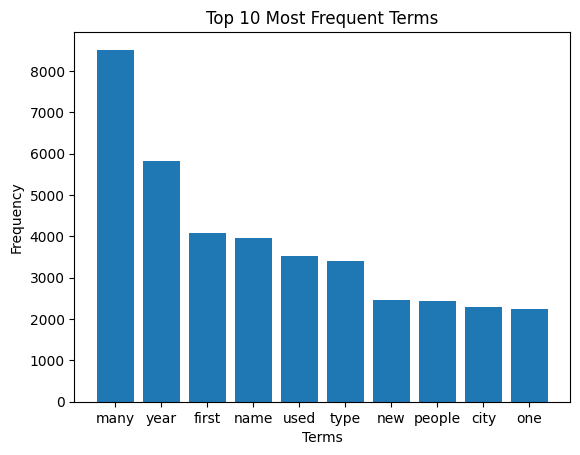

In [8]:
import matplotlib.pyplot as plt

most_common_words = counts_total.most_common(10)
terms, frequencies = zip(*most_common_words)

# Plot the distribution of the 10 most frequent words
plt.bar(terms, frequencies)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Terms')
plt.show()

## Word2Vec embedding

Word2Vec is used for NLP which is able to produce word embedding (words with similar meaning have similar representation), and with this we can perform many comparisons. Depending on the parameters we use for the Word2Vec model, we'll get different precision as well as different results. The min_count parameter value takes into consideration only the words that occur more than this value in the entire text. The vector_size parameter defines the number of dimensions the words are mapped onto: the default value is 100 and if we increase it we can have a more accurate model but also we need more training data. The window parameter takes into consideration n words around the target word that affect it.

We trained the model removing stopwords since the results should be more precise and stopwords are not necessary for our purposes. In all cases, the parameter 'sentences' contains the sentences with stop words included.

In [9]:
sentences = text_to_sentence_train
sentences2 = text_to_sentence_no_stopwords_train

# train model with two inputs: one with stopwords and the other without
model = Word2Vec(sentences=sentences2, vector_size=30, min_count = 5, window=2)

With word embedding using Word2Vec we can perform different types of comparison. The similarity among vectors associated with the terms is computed using the cosine similarity model.

Some examples of tasks we are able to with Word2Vec:
- retrieved the vector associated with the specific word in the dictionary, e.g. 'city'
- retrieve all most similar words to a given term, e.g. 'city', 'food'
- retrieve the word that doesn't match the others in a list
- retrieve the similarity between two words, e.g. 'woman' and 'man'
- retrieve the most similar term to a given word and the similarity value, e.g. 'napoleon', 'child'
- retrieve the similarity between two sets of words

It is interesting to notice that some results are the ones expected (for example woman and man are actually similar in terms of their meaning, as well as almost all words returned if we search for similar terms using as reference 'city'). In other cases the results are not the expected ones, e.g. the returned word (which can vary) is almost always not the most similar term with respect to 'child', or the majority of the words returned within the list of similar words with respect to 'food'. These discrepancies can be due to the parameters passed to the Word2Vec model: in general, a higher value for the parameter vector_size leads to a better accuracy, but for small corpus sizes we can obtain a good accuracy even with small values (i.e. 30 or smaller). The same resoning can be applied to the window value where an higher value leads to an higher quality. Another cause of these misleading results is the size of the training set that in our case is limited and we are not able to increase it. A last reasoning can be made about how to separate the sentences: we used unigrams and this means that each sentence is a list of single words, but it is also possible to use bigrams (or more in general n-grams) since some words are composed by two or more words (e.g. San Francisco, look up, etc.), thus separation in n-grams can be useful to detect and maintain words together.

In [10]:
# number of word vectors the model learned
res = model.wv
print(len(res), "\n")

# example vector for word 'city'
print("Vector for word 'city':\n", res['city'], "\n")

# similarity with word 'city'
print("Words similar to 'city':\n", res.most_similar("city"), "\n")
print("Words similar to 'food':\n", res.most_similar("food"), "\n")

# word that doesn't match with other words
print("Word not matching 'city, home, food, street':\n",res.doesnt_match("city home food street".split()), "\n")

# expected similarity between two words
similarity = res.similarity('woman', 'man')
print("Similarity between 'man' and 'woman' is greater than 80%:\n", similarity > 0.8, "\n")

# most similar word to the given one
result = res.similar_by_word("napoleon")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'napoleon': \n", f"{most_similar_key}: {similarity:.4f}")

result = res.similar_by_word("child")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'child': \n",f"{most_similar_key}: {similarity:.4f}")

# similarity between two sets of words
similarity = res.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])
print("Similarity between ['sushi', 'shop'] and ['japanese','restaurant']:", similarity)



13495 

Vector for word 'city':
 [-1.2547193  -0.46245575  1.4241488   0.5898398  -1.3756877   0.8132388
 -0.8780038   0.8960212  -0.03736721 -2.153792   -0.2674474   1.3644025
 -0.64691484  0.5064375  -1.2314119  -1.0388628   0.01981079 -0.4711378
 -0.9955127   0.06889933  1.8361984   1.9923283   1.2358129  -0.4526328
  1.2195206  -1.8956021  -0.5967035   0.9351813   2.5976427  -0.25998148] 

Words similar to 'city':
 [('area', 0.8841292262077332), ('county', 0.8410311341285706), ('district', 0.8238941431045532), ('museum', 0.8132593035697937), ('london', 0.8111844658851624), ('store', 0.8060264587402344), ('university', 0.7999951243400574), ('territory', 0.792898952960968), ('province', 0.7875227332115173), ('station', 0.7831853628158569)] 

Words similar to 'food':
 [('physical', 0.9344302415847778), ('knowledge', 0.9238395690917969), ('light', 0.9147899746894836), ('heat', 0.9063076376914978), ('content', 0.8942327499389648), ('radiation', 0.8938672542572021), ('storage', 0.8894476

We now compare the results above with the ones obtained increasing the vector_size and window parameters with respective values of 100 and 10. The results are not improved (some of them are even worst) in a significant way and this means that the parameter's values in this case are not able to obtain better similarity values.

In [11]:
model_precise = Word2Vec(sentences=sentences2, vector_size=100, min_count = 5, window=10)

In [12]:
res = model_precise.wv
print(len(res), "\n")

print("Vector for word 'city':\n", res['city'], "\n")

print("Words similar to 'city':\n", res.most_similar("city"), "\n")
print("Words similar to 'food':\n", res.most_similar("food"), "\n")

print("Word not matching 'city, home, food, street':\n",res.doesnt_match("city home food street".split()), "\n")

similarity = res.similarity('woman', 'man')
print("Similarity between 'man' and 'woman' is greater than 80%:\n", similarity > 0.8, "\n")

result = res.similar_by_word("napoleon")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'napoleon': \n", f"{most_similar_key}: {similarity:.4f}")

result = res.similar_by_word("child")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'child': \n",f"{most_similar_key}: {similarity:.4f}")

similarity = res.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])
print("Similarity between ['sushi', 'shop'] and ['japanese','restaurant']:", similarity)

13495 

Vector for word 'city':
 [-1.3181144e+00  1.6191424e+00  1.2426248e+00  5.2625024e-01
 -5.7891625e-01 -1.1275086e+00  1.3898435e+00  9.7241735e-01
 -4.9088699e-01 -1.1209129e+00  2.5441951e-01  4.3161029e-01
  9.1717851e-01 -1.4776008e+00 -2.2282717e-01  5.5362219e-01
  6.2568367e-01 -4.6310869e-01 -1.7998037e+00 -7.5948161e-01
  4.1978648e-03 -2.2895768e-01  7.5943321e-02 -1.1955526e+00
  6.8391830e-01 -1.2416484e+00 -1.3284817e+00 -1.5045573e-01
 -1.3568723e+00 -3.5182416e-02  6.7856747e-01  2.6006106e-01
  6.2845671e-01  2.6347405e-01 -1.0489057e+00  1.1882831e+00
  5.8905786e-01 -1.0713961e+00  1.6280097e+00 -6.0309279e-01
  7.7417701e-01 -6.5761775e-01 -4.0547922e-01 -1.5964733e+00
  1.0917524e+00 -1.3746425e+00  8.4945047e-01  5.2767330e-01
  7.2772577e-02  8.6151040e-01  1.8883455e-01  9.3668181e-01
 -1.3571577e-01  1.7312289e+00  4.5437194e-02  6.2380987e-01
  1.0818108e+00 -7.2924221e-01 -1.0240315e+00  1.3497803e+00
  1.9373682e+00  2.9208976e-01  4.3139568e-01 -1.802

# Train and evaluate model

## Train the model to perform the specific task

## Test pre-trained models on the task if they already exist

## Investigate the effectiveness of Large Language Models (LLMs) together with zero-shot and/or few-shot learning on the task

## Evaluate the different methods and compare their performance across a representative test set

# Add voice interactivity

## Speech-to-text

For the speech-to-text it is possible to register the audio with the structure used in the tutorial during the course. To register, run block below with 'get_audio()'. The recording is then stored locally as file in the notebook.

In [13]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [15]:
audio, sr = get_audio()
audio = np.array(audio, dtype=float)
# store custom audio file recorded
scipy.io.wavfile.write('audio.wav', sr, audio)

### audio analysis
Plot the amplitude with respect to the samples (sr stands for sampling rate, and 1sr = sampling rate of 1 Hz = 1 sampling per second).

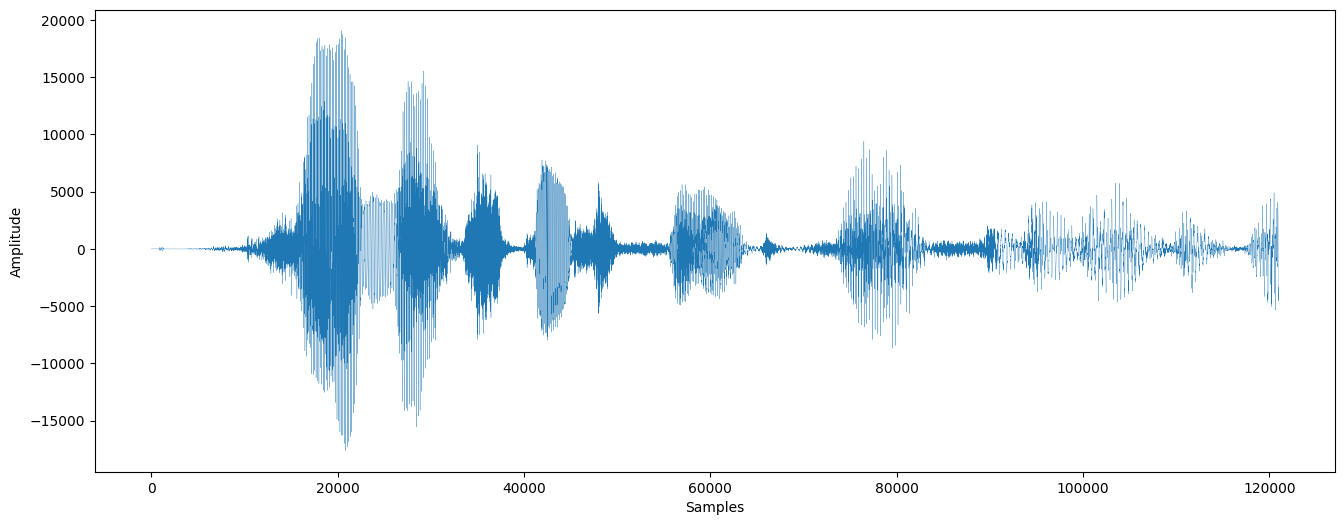

In [16]:
fig = plt.figure(figsize=(16, 6))

plt.plot(audio, linewidth=0.2)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

Plot the spectrogram (amplitude with respect to time), knowing how many samples we have per second (sr) and the total duration of the audio file

Duration of the custom file audio: 2.52 s.



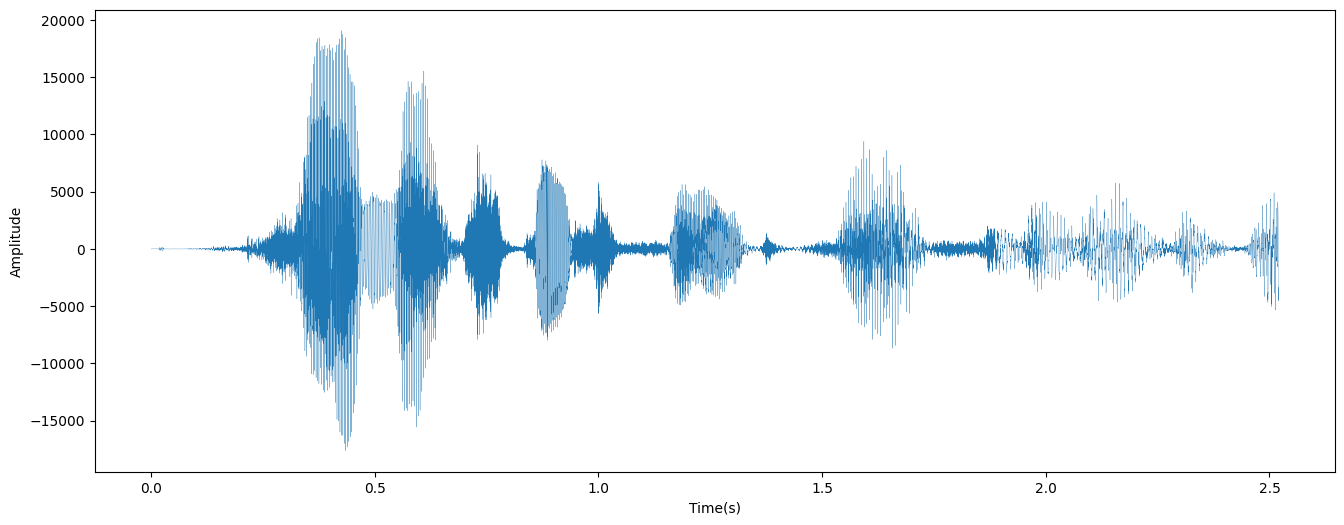

In [17]:
# get duration in seconds
audio_length = librosa.get_duration(y=audio, sr=sr)
size_audio = len(audio)
print("Duration of the custom file audio:", audio_length, "s.\n")
fig = plt.figure(figsize=(16, 6))
# change x axis to take into consideration time and not samples
plt.plot(np.linspace(0, audio_length, size_audio), audio, linewidth=0.2)
plt.ylabel('Amplitude')
plt.xlabel('Time(s)')
plt.show()




### Windowing CHANGE?? MEL?
In general before the application of Fast Fourier Transform we need to ensure to make it work in the best way possible. This method has some limitation, thus it is required to perform some modifications on the signal before using it, that is, windowing. The assumption done by the FFT is that there is a finite set of data. It sees the time wave as circular, then as the two endpoints (edges) are connected, expecting the signal to have an integer number of periods. The problem is that often the two endpoints of the wave signal doesn't match (not continuous if connected together), thus not having an integer number of periods. This causes in the result of the FFT peaks of high frequency (sharp transitions) which are not present in the original signal, which cause a distorted result. Windowing is used to reduce these peaks by segmenting the signal into windows and smoothing the signal toward zero at the endpoints.

Different windowing methods can be used, and the Hann windowing is the one who permits the signal to touches the 0 value amplitude at the edges by smoothing the signal, thus removing all discontinuities. The whisper model uses this method where a window is slides along the signal.

### Whisper model
The whisper model is the state of art of speech recognition: it permits a robust speech processing as well as the ability to recognise multiple languages. In this project we assume spoken questions are passed in English.

Even if we use one of the most powerful model, passing directly the .wav recording doesn't permit to get most of the times a correct transcription which is very important in our project. We tried to use the large model and the precision improved, however not as the level as we expected. A solution is to preprocess the audio file in combination with the use of the large model: we apply normalisation (usually done also for images) which permit the model to easily compute as well as noise reduction to have a clearer recording. The results improve even more if the recording is done with an artificial voice (e.g. the one of Google translator), since the spelling is better than the one of a person's voice.


In [18]:
model = whisper.load_model("large")

In [19]:
# result without preprocessing
result = model.transcribe('audio.wav')
print("Transcription of the custom audio: ", result['text'])

Transcription of the custom audio:   How much does food cost?


In [20]:
import noisereduce as nr
# result with preprocessing audio
# normalize audio using mean and standard deviation

# Compute mean and standard deviation
mean_value = np.mean(audio)
std_dev = np.std(audio)
# Normalize the audio
normalized_audio = (audio - mean_value) / std_dev

# reduce noise
reduced_noise = nr.reduce_noise(y=normalized_audio, sr=sr)
# store new  preprocessed audio file recorded before
scipy.io.wavfile.write('audio.wav', sr, reduced_noise)

In [21]:
result = model.transcribe('audio.wav')
print("Transcription of the custom audio: ", result['text'])

question = result['text'].lower

Transcription of the custom audio:   How much does fruit cost?


### Mel spectrogram

## Text-to-speech

For transforming text to speech we employ the Tacotron2 as well as WaveGlow. Tacotron2 is able to produce Mel spectrogram from a given text using an encoder-decoder architecture, thus we need WaveGlow which is able to produce audio files from Mel spectrograms. We load the Tacotron2 model pre-trained on LJ Speech dataset from NVIDIA's Deep Learning Examples repository as well as the pretrained WaveGlow model

For better performance tacotron2 and waveglow are moved to the GPU if available ('cuda'), and they're then moved to the evaluation mode (remotion of some layers which are not necessary outside the training part). Weight normalisation is removed from waveglow since it is used for training purposes.

In [22]:
import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [23]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

In [46]:
# input_text = question
input_text = 'quando e morto napoleone'

Process the input using utilities to prepare it for TTS model.

In [47]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([input_text])

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Combine Tacotron2 and WaveGlow.

torch.no_grad() disables gradient computation during its execution (for memory saving and computation speed up)

In [48]:
with torch.no_grad():
    mel, _, _ = (sequences, lengths)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
sr2 = 22050

ValueError: ignored

In [ ]:
fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mel[0].cpu().numpy())
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [10ms]')
plt.show()

Store audio file

In [27]:
scipy.io.wavfile.write("text_to_speech.wav", sr2, audio_numpy)

Listen for the text

In [39]:
sr, audio = scipy.io.wavfile.read("text_to_speech.wav")

# Display the audio player widget
Audio(data=audio, rate=sr)

## Investigate how effective and reliable the voice interactive components are

## If they are not particularly reliable, how might you change them to make them more robust?

# References
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/


https://stackoverflow.com/a/18650249


https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/


https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/


https://stackoverflow.com/a/49019356


https://librosa.org/doc/main/index.html

https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf

https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/